# Tests and implementation for the RFClassifier class.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from estimator import RFClassifier, classical_weights, V1_inspired_weights, haltere_inspired_weights

## Implementation for V1 weights

In [12]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data, labels = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [13]:
# select the linear classifier
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver='saga')

# non-linearity
relu = lambda x: np.maximum(0, x)

# classify using classical weights
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(width=40, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

# classify using V1 weights
kwargs = {'t': 5, 'l': 3}
params_neural = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity':relu, 'clf': logit}
clf = RFClassifier(width=40, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9444444444444444


/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8388888888888889


## Implementation for haltere weights

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data, labels = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

0.8859649122807017
0.8771929824561403


/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


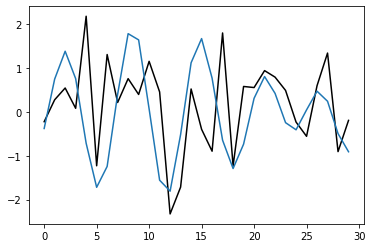

In [15]:
# linear classifier
logit = LogisticRegression(solver='saga')

# non-linearity
cos = lambda x: np.cos(x)
relu = lambda x: np.maximum(x, 0)

# params
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_classical = clf.W_[0]

kwargs = {'lowcut': 4, 'highcut': 6}
params_neural = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_neural = clf.W_[0]

fig = plt.figure()
plt.plot(W_classical, c='k')
plt.plot(W_neural)

### Test the parallelized function for RFClassifer

In [16]:
from estimator import RFClassifier, classical_weights, relu, haltere_inspired_weights, V1_inspired_weights, clf_wrapper
from data_fns import load_mnist
from sklearn.linear_model import SGDClassifier
import numpy as np
import numpy.linalg as la

In [17]:
# use dask
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [18]:
X_train, y_train, X_test, y_test = load_mnist('data/mnist/')
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [19]:
%%time
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-4, n_iter_no_change=10, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
train_err, test_err, clf = clf_wrapper(RFClassifier, params, X_train, y_train, X_test, y_test, return_clf=True)
print(test_err)

0.9444
CPU times: user 6min 15s, sys: 2min 11s, total: 8min 26s
Wall time: 25.1 s


In [20]:
%%time
from estimator import parallelized_clf
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-5, n_iter_no_change=30, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
mean_train_err, std_train_err, mean_test_err, std_test_err = parallelized_clf(RFClassifier, params, X_train, y_train,
                                                                             X_test, y_test, n_iters=5, 
                                                                              return_clf=False)

CPU times: user 27.6 s, sys: 7.73 s, total: 35.4 s
Wall time: 2min 26s


In [21]:
1 - mean_test_err

0.037919999999999954